# Exercise 1: Linear Image Classifier

In this exercise you will implement a linear image classifier while getting familiar with `numpy` and the benefits of vectorized operations in Python. This exercise has 2 parts:

1. Implementing loss functions, calculating gradients and implementing gradient descent.
2. Training and evaluating several classifiers.

## Submission guidelines:

Your submission should only include this jupyter notebook named ex1_ID.ipynb.

## Read the following instructions carefully:

1. This jupyter notebook contains all the step by step instructions needed for this exercise.
2. Write **efficient vectorized** code whenever instructed. 
3. You are responsible for the correctness of your code and should add as many tests as you see fit. Tests will not be graded nor checked.
4. Do not change the functions we provided you. 
4. Write your functions in this jupyter notebook only.
5. You are allowed to use functions and methods from the [Python Standard Library](https://docs.python.org/3/library/) and [numpy](https://www.numpy.org/devdocs/reference/) only in your implementations. Any other imports are forbidden.
6. Your code must run without errors.
7. Write your own code. Cheating will not be tolerated. 
8. Answers to qualitative questions should be written in **markdown** cells (with $\LaTeX$ support).

Q: What files do we need to upload to moodle?

A: 

Q: Should you run your code and make sure everything works just before you submit? What will happen if your code cannot run?

A:

Q: Should you add any other files in your submission?

A:

#### Imports

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle
import numpy as np
import os
import sys
import urllib.request
import tarfile
import zipfile
from random import randrange
from functools import partial
import itertools

# specify the way plots behave in jupyter notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 10.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Data preprocessing


## Data download and processing Helper Code

In [4]:
def _print_download_progress(count, block_size, total_size):
    """
    Function used for printing the download progress.
    Used as a call-back function in maybe_download_and_extract().
    """

    # Percentage completion.
    pct_complete = float(count * block_size) / total_size

    # Limit it because rounding errors may cause it to exceed 100%.
    pct_complete = min(1.0, pct_complete)

    # Status-message. Note the \r which means the line should overwrite itself.
    msg = "\r- Download progress: {0:.1%}".format(pct_complete)

    # Print it.
    sys.stdout.write(msg)
    sys.stdout.flush()

def download(base_url, download_dir):
    """
    Download the given file if it does not already exist in the download_dir.
    :param base_url: The internet URL without the filename.
    :param filename: The filename that will be added to the base_url.
    :param download_dir: Local directory for storing the file.
    :return: Nothing.
    """

    # Path for local file.
    filename = base_url.split("/")[-1]
    save_path = os.path.join(download_dir, filename)

    # Check if the file already exists, otherwise we need to download it now.
    if not os.path.exists(save_path):
        # Check if the download directory exists, otherwise create it.
        if not os.path.exists(download_dir):
            os.makedirs(download_dir)

        print("Downloading", filename, "...")

        # Download the file from the internet.
        file_path, _ = urllib.request.urlretrieve(url=base_url,
                                                  filename=save_path,
                                                  reporthook=_print_download_progress)

        print(" Done!")

def maybe_download_and_extract(url, download_dir):
    """
    Download and extract the data if it doesn't already exist.
    Assumes the url is a tar-ball file.
    :param url:
        Internet URL for the tar-file to download.
        Example: "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
    :param download_dir:
        Directory where the downloaded file is saved.
        Example: "data/CIFAR-10/"
    :return:
        Nothing.
    """

    # Filename for saving the file downloaded from the internet.
    # Use the filename from the URL and add it to the download_dir.
    filename = url.split('/')[-1]
    file_path = os.path.join(download_dir, filename)

    # Check if the file already exists.
    # If it exists then we assume it has also been extracted,
    # otherwise we need to download and extract it now.
    if not os.path.exists(file_path):
        # Check if the download directory exists, otherwise create it.
        if not os.path.exists(download_dir):
            os.makedirs(download_dir)

        # Download the file from the internet.
        file_path, _ = urllib.request.urlretrieve(url=url,
                                                  filename=file_path,
                                                  reporthook=_print_download_progress)

        print()
        print("Download finished. Extracting files.")

        if file_path.endswith(".zip"):
            # Unpack the zip-file.
            zipfile.ZipFile(file=file_path, mode="r").extractall(download_dir)
        elif file_path.endswith((".tar.gz", ".tgz")):
            # Unpack the tar-ball.
            tarfile.open(name=file_path, mode="r:gz").extractall(download_dir)

        print("Done.")
    else:
        print("Data has apparently already been downloaded and unpacked.")

def load_CIFAR_batch(filename):
    ''' load single batch of cifar '''
    with open(filename, 'rb') as f:
        datadict = pickle.load(f, encoding = 'latin1')
        X = datadict['data']
        Y = datadict['labels']
        X = X.reshape(10000, 3, 32, 32).transpose(0, 2, 3, 1).astype("float")
        Y = np.array(Y)
        return X, Y

def load(ROOT):
    ''' load all of cifar '''
    xs = []
    ys = []
    for b in range(1, 6):
        f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
        X, Y = load_CIFAR_batch(f)
        xs.append(X)
        ys.append(Y)
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    del X, Y
    Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
    return Xtr, Ytr, Xte, Yte

## Data Download

The next cell will download and extract CIFAR-10 into `datasets/cifar10/`. The CIFAR-10 dataset consists of 60,000 32x32 color images in 10 classes, with 6,000 images per class. There are 50,000 training images and 10,000 test images. The dataset is divided into five training batches and one test batch, each with 10,000 images. The test batch contains exactly 1,000 randomly-selected images from each class.


In [5]:
# this cell will download the data if it does not exists
URL = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
PATH = 'datasets/cifar10/' # the script will create required directories
maybe_download_and_extract(URL, PATH) 

Data has apparently already been downloaded and unpacked.


## Data Preprocessing Part 1

We have included several image processing functions. Notice the following in particular: we created an additional validation dataset you need to use for hyperparameter optimization.

In [6]:
CIFAR10_PATH = os.path.join(PATH, 'cifar-10-batches-py')
X_train, y_train, X_test, y_test = load(CIFAR10_PATH) # load the entire data

# taking only two classes from the dataset
X_train = X_train[np.logical_or(y_train == 0, y_train == 1)]
y_train = y_train[np.logical_or(y_train == 0, y_train == 1)]
X_test = X_test[np.logical_or(y_test == 0, y_test == 1)]
y_test = y_test[np.logical_or(y_test == 0, y_test == 1)]

# define a splitting for the data
num_training = 10000
num_validation = 1000
num_testing = 1000

# add a validation dataset for hyperparameter optimization
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]
mask = range(num_validation)
X_val = X_test[mask]
y_val = y_test[mask]
mask = range(num_validation, num_validation+num_testing)
X_test = X_test[mask]
y_test = y_test[mask]

# float64
X_train = X_train.astype(np.float64)
X_val = X_val.astype(np.float64)
X_test = X_test.astype(np.float64)

classes = ('plane', 'car')

    plane       car     plane     plane


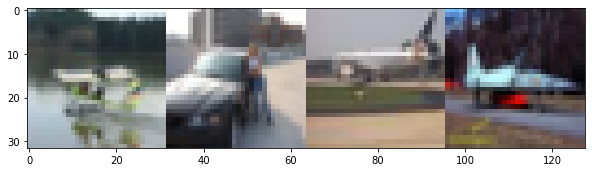

In [7]:
def get_batch(X, y, n=1000):
    rand_items = np.random.randint(0, X.shape[0], size=n)
    images = X[rand_items]
    labels = y[rand_items]
    return images, labels

def make_random_grid(x, y, n=4, convert_to_image=True, random_flag=True):
    if random_flag:
      rand_items = np.random.randint(0, x.shape[0], size=n)
    else:
      rand_items = np.arange(0, x.shape[0])
    images = x[rand_items]
    labels = y[rand_items]
    if convert_to_image:
      grid = np.hstack(np.array([np.asarray((vec_2_img(i) + mean_image), dtype=np.int) for i in images]))
    else:
      grid = np.hstack(np.array([np.asarray(i, dtype=np.int) for i in images]))
    print(' '.join('%9s' % classes[labels[j]] for j in range(n)))
    return grid

def vec_2_img(x):
    x = np.reshape(x[:-1], (32, 32, 3))
    return x

X_batch, y_batch = get_batch(X_test, y_test, 100)
plt.imshow(make_random_grid(X_batch, y_batch, convert_to_image=False));

## Data Preprocessing Part 2

We have included several image processing functions. Notice the following in particular: We subtracted the mean from all the images in order to ignore illumination conditions while keeping the content of the image. Next, we flattened the images from a tensor of shape (32x32x3) to a vector with 3072 features (pixel values) so we would be able to use a simple matrix multiplication. Finally, we concatenated each image vector with an additional feature to account for the bias. This is known as the bias trick. 

Make sure you understand this image processing pipeline before diving into the rest of the code.

In [8]:
# Final data preprocessing
# subtract the mean from all the images in the batch
mean_image = np.mean(X_train, axis=0)
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image

# flatten all the images in the batch (make sure you understand why this is needed)
X_train = np.reshape(X_train, newshape=(X_train.shape[0], -1))
X_val = np.reshape(X_val, newshape=(X_val.shape[0], -1)) 
X_test = np.reshape(X_test, newshape=(X_test.shape[0], -1)) 

# add a bias term to all images in the batch
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))]) 
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))]) 
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))]) 

print(f"Shape of Training Set: {X_train.shape}")
print(f"Shape of Validation Set: {X_val.shape}")
print(f"Shape of Test Set: {X_test.shape}")

Shape of Training Set: (10000, 3073)
Shape of Validation Set: (1000, 3073)
Shape of Test Set: (1000, 3073)


# Linear classifier: mapping images to scores

During this exercise, we will maintain a python class with basic functionality (such as training the model). the linear classifiers we will build (perceptron, logistic regression) will inherit some functionality from that class and will change several functions (such as the loss function, for example). Read the code in the next cell and make sure you understand it. You might also find this [short classes in python tutorial](https://www.hackerearth.com/practice/python/object-oriented-programming/classes-and-objects-i/tutorial/) useful.


In [9]:
class LinearClassifier(object):
    def __init__(self, X, y):
        """
        Class constructor. Use this method to initiate the parameters of
        your model (W)
        *** Subclasses will override this. ***

        Inputs:
        - X: array of data
        - y: 1-dimensional array of length N with binary labels

        This function has no return value

        """
        num_features = X.shape[1]
        num_classes = np.max(y) + 1 # assume y takes values 0...K-1 where K is number of classes
        self.W = 0.0001 * np.random.randn(num_features, num_classes)        

    def predict(self, X):
        """
        Use the weight of the classifier to predict a label. 
        *** Subclasses will override this. ***

        Input: 2D array of size (num_instances, num_features).
        Output: 1D array of class predictions (num_instances, 1). 
        """
        pass

    def calc_accuracy(self, X, y):
        """
        Calculate the accuracy on a dataset as the percentage of instances 
        that are classified correctly. 

        Inputs:
        - W: array of weights
        - X: array of data
        - y: 1-dimensional array of length N with binary labels
        Returns:
        - accuracy as a single float
        """

        accuracy = 0.0
        ###########################################################################
        # TODO:                                                                   #
        # Implement this method.                                                  #
        ###########################################################################
        
 
        y_pred = self.predict(X)
        accuracy = np.mean(np.invert(np.logical_xor(y_pred, y)))

        ###########################################################################
        #                           END OF YOUR CODE                              #
        ###########################################################################

        return accuracy


    def train(self, X, y, learning_rate=1e-3, num_iters=100, batch_size=200, verbose=False):
        #########################################################################
        # TODO:                                                                 #
        # Sample batch_size elements from the training data and their           #
        # corresponding labels to use in every iteration.                       #
        # Store the data in X_batch and their corresponding labels in           #
        # y_batch                                                               #
        #                                                                       #
        # Hint: Use np.random.choice to generate indices. Sampling with         #
        # replacement is faster than sampling without replacement.              #
        #                                                                       #
        # Next, calculate the loss and gradient and update the weights using    #
        # the learning rate. Use the loss_history array to save the loss on     #
        # iteration to visualize the loss.                                      #
        #########################################################################
        num_instances, num_features = X.shape
        num_classes = np.max(y) + 1
        loss_history = []
        loss = 0.0
        for i in range(num_iters):
            
            X_batch = None
            y_batch = None

            ###########################################################################
            #                          START OF YOUR CODE                             #
            # TODO:                                                                   #
            # get a batch by randomly sampling the train set, calculate a loss and    #
            # gradient, and add the loss to the loss history                          #
            ###########################################################################
            
            idx = np.random.choice(num_instances, batch_size)
            X_batch, y_batch = X[idx,:], y[idx]
            
            loss, gradient = self.loss(X_batch, y_batch)
            loss_history.append(loss)
            
            ###########################################################################
            #                           END OF YOUR CODE                              #
            ###########################################################################

            # perform parameter update
            #########################################################################
            #                          START OF YOUR CODE                           #
            # TODO:                                                                 #
            # Update the weights using the gradient and the learning rate.          #
            #########################################################################
            self.W -= learning_rate*gradient 

            #########################################################################
            #                       END OF YOUR CODE                                #
            #########################################################################

            if verbose and i % 100 == 0:
                print ('iteration %d / %d: loss %f' % (i, num_iters, loss))

        return loss_history

        

    def loss(self, X, y):
        """
        Compute the loss function and its derivative. 
        Subclasses will override this.
        Inputs:
        - X_batch: A numpy array of shape (N, D) containing a minibatch of N
          data points; each point has dimension D.
        - y_batch: A numpy array of shape (N,) containing labels for the minibatch.
        Returns: A tuple containing:
        - loss as a single float
        - gradient with respect to self.W; an array of the same shape as W
        """
        pass

## Linear perceptron
Our first linear classifier will include a linear function that maps images to scores:

$$
f(x_i; W, b) = W\cdot x_i + b
$$

As you learned in class, this linear classifier takes an input image $x_i$ and outputs a class score. Your goal is to **learn** the parameters $W$ and $b$ to best classify the images according to the provided labels. The linear perceptron is set up so that the perceptron learn to map the correct class for each image such that it will have a score higher than the incorrect class.

Read the next code cell. The constructor of the `LinearPerceptron` class takes as input the dataset and labels in order to create appropriate parameters. Notice we are using the bias trick and only use the matrix `w` for convenience. Since we already have a (random) model, we can start predicting classes on images. Complete the method `predict` in the `LinearPerceptron` class. **(5 Points)**

In [10]:
class LinearPerceptron(LinearClassifier):
    # Classifier that uses Perceptron loss

    def __init__(self, X, y):
        self.W = None
        ###########################################################################
        #                          START OF YOUR CODE                             #
        # TODO:                                                                   #
        # Initiate the parameters of your model.                                  #
        ###########################################################################
        
        super().__init__(X, y)
        num_features = X.shape[1]
        self.W = 0.0001 * np.random.randn(num_features, 1)
        
        ###########################################################################
        #                           END OF YOUR CODE                              #
        ###########################################################################

        
    def predict(self, X):
        y_pred = None
        ###########################################################################
        # TODO:                                                                   #
        # Implement this method.                                                  #
        ###########################################################################

        y_pred = self.W.T @ X.T
        y_pred = np.where(y_pred >= 0, 1, 0)
        y_pred = np.squeeze(y_pred)
        
        ###########################################################################
        #                           END OF YOUR CODE                              #
        ###########################################################################
        return y_pred


    def loss(self, X_batch, y_batch):
        return perceptron_loss_vectorized(self.W, X_batch, y_batch)

In [11]:
classifier = LinearPerceptron(X_train, y_train)
y_pred = classifier.predict(X_test)

    plane       car     plane       car


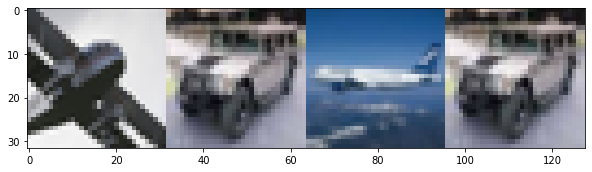

In [12]:
X_batch, y_batch = get_batch(X_train, y_train, 4)
plt.imshow(make_random_grid(X_batch, y_batch))
plt.show()

In [13]:
# predictions
print(' '.join('%9s' % classes[y_pred[j]] for j in range(4)))

      car       car     plane       car


## Evaluation 

Complete the class method `calc_accuracy`. Explain why the accuracy on the training dataset (remember, the model is not trained yet) is around 50%. **(5 Points)**

In [14]:
print("model accuracy: ", classifier.calc_accuracy(X_train, y_train))

model accuracy:  0.4862


**Your answer here:**  

Since the model is not trained yet, the predictions are as a random guess (as tossing a fair coin). Meaning:
$$ P(Y=1|X=x)=P(Y=0|X=x)=0.5 \; \; \forall x \in X$$

Thus, the number of successes: correct predictions is binomially distributed random variable $$ \sim{B(n,0.5)}$$
The expected value of such variable is: $$ E[Y] = np = n\frac{1}{2} \; such\; that \;n:= number\; of\; inputs $$ 


$ \rightarrow $ So $P=0.5 $ to be right and multiply by the number of examples we get Accuracy of 50%

## Perceptron loss

Your code for this section will all be written in the next cell. In this section, we write and test code outside the classes for convenience. Notice the loss method for each class is just a call for the loss function written in the next cell. Once you are finished with implementation, everything should work.

First, complete the function `perceptron_loss_naive`. This function takes as input the weights, data, labels and outputs the calculated loss as a single number and the gradients with respect to W.  **(15 points)**

In [15]:
def perceptron_loss_naive(W, X, y):
    """
    Structured perceptron loss function, naive implementation (with loops)
    Inputs:
    - W: array of weights
    - X: array of data
    - y: 1-dimensional array of length N with labels 0...K-1, for K classes
    Returns:
    a tuple of:
    - loss as single float
    - gradient with respect to weights W; an array of same shape as W
    """
    loss = 0.0
    dW = np.zeros(W.shape) # initialize the gradient as zero
    #############################################################################
    # TODO:                                                                     #
    # Compute the perceptron loss as learned in class. Start by iterating over  #
    # over all instances and calculate the score and true score for each.       #
    # Now, for each class determine if the prediction is correct and update the #
    # loss over all mistakes.                                                   #
    # Compute the gradient of the loss function and store it as dW.             #
    # Rather than first computing the loss and then computing the derivative,   #
    # it may be simpler to compute the derivative at the same time that the     #
    # loss is being computed.                                                   #
    #############################################################################

    for i, x in enumerate(X):
        t = y[i] if y[i] == 1 else -1
        z = W.T @ x
        tz = t * z
        loss += np.maximum(0, -tz)
        if tz < 0:
            dW -= np.expand_dims(t * x, axis=1)
            
    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################
    return loss/X.shape[0], dW/X.shape[0]

In [12]:
# weights are of the form FEATURES X CLASS (in the binary case CLASS=1)
W = np.random.randn(3073, 1) * 0.0001

In [16]:
%%time
loss_naive, grad_naive = perceptron_loss_naive(W, X_val, y_val)
print ('loss: %f' % (loss_naive, ))

loss: 0.160872
CPU times: user 36.8 ms, sys: 5.39 ms, total: 42.2 ms
Wall time: 38.3 ms


Once your code works, complete the function `perceptron_loss_vectorized` and compare the results of the two functions using the cell below. **(15 points)**

In [13]:
def perceptron_loss_vectorized(W, X, y):
    """
    Vectorized version of perceptron_loss_naive. Instead of loops, should use 
    numpy vectorization.

    Inputs and outputs are the same as perceptron_loss_naive.
    """
    loss = 0.0
    dW = np.zeros(W.shape) # initialize the gradient as zero
    #############################################################################
    # TODO:                                                                     #
    # Implement a vectorized version of the perceptron loss, storing the       #
    # result in loss and the gradient in dW                                     #
    #############################################################################

    t = np.where(y == 1, 1, -1)
    z = W.T @ X.T
    tz = np.multiply(t, z)  # pair-wise multiplication
    loss += np.mean(np.maximum(0.0, -tz))
    indicator_vec = np.where(tz < 0, 1, 0)
    Itx = indicator_vec * t.T * X.T
    print(Itx.shape)
    dW -= np.expand_dims(np.mean(Itx, axis=1), axis=1)

    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################
    return loss, dW

In [17]:
%%time

loss_vectorized, grad_vectorized = perceptron_loss_vectorized(W, X_val, y_val)
print ('loss: %f' % (loss_vectorized, ))

difference = np.linalg.norm(grad_naive - grad_vectorized)
print ('difference: %f' % difference)

(3073, 1000)
loss: 0.160872
difference: 0.000000
CPU times: user 24.9 ms, sys: 13.5 ms, total: 38.3 ms
Wall time: 14.4 ms


We have obtained an efficient function for loss and gradient calculation and we can now train our network. Complete the function `train` in the `LinearClassifier` class. (**10 points**)

In [20]:
%%time
perceptron = LinearPerceptron(X_train, y_train)
loss_history = perceptron.train(X_train, y_train, learning_rate=1e-7, 
                                num_iters=1500, verbose=True)

iteration 0 / 1500: loss 0.156280
iteration 100 / 1500: loss 0.049140
iteration 200 / 1500: loss 0.025569
iteration 300 / 1500: loss 0.024440
iteration 400 / 1500: loss 0.024603
iteration 500 / 1500: loss 0.017944
iteration 600 / 1500: loss 0.011411
iteration 700 / 1500: loss 0.013499
iteration 800 / 1500: loss 0.018554
iteration 900 / 1500: loss 0.015777
iteration 1000 / 1500: loss 0.015488
iteration 1100 / 1500: loss 0.014171
iteration 1200 / 1500: loss 0.016329
iteration 1300 / 1500: loss 0.012848
iteration 1400 / 1500: loss 0.013007
CPU times: user 14.3 s, sys: 10.1 s, total: 24.4 s
Wall time: 21.4 s


Text(0.5, 0, 'Iteration number')

Text(0, 0.5, 'Loss value')

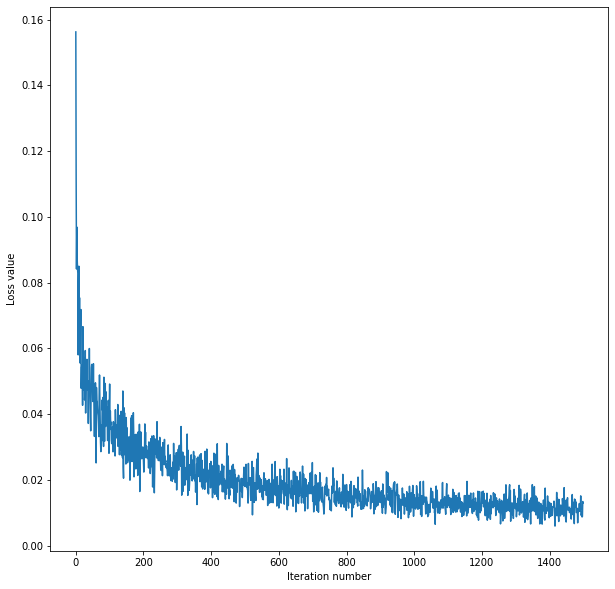

In [21]:
plt.plot(loss_history)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [22]:
print("Training accuracy: ", perceptron.calc_accuracy(X_train, y_train))
print("Testing accuracy: ", perceptron.calc_accuracy(X_test, y_test))

Training accuracy:  0.7615
Testing accuracy:  0.735


## Hyperparameter optimization

Your model should have improved from 50% accuracy to ~75% accuracy in a matter of seconds. Now, use the validation set to tune hyperparameters by training different models (using the training dataset) and evaluating the performance using the validation dataset. Save the results in a dictionary mapping tuples of the form `(learning_rate, batch_size)` to tuples of the form `(training_accuracy, validation_accuracy)`. Finally, you should evaluate the best model on the testing dataset. 

Note: When changing the batch_size, change the number of iterations accordingly such that the number of epochs on the data stays roughly the same. A reasonable ratio is 600 iterations for a batch size of 200. 

If you are carful you should reach ~83% accuracy on the validation dataset.

Use a small value for the number of iterations as you develop your code. Once you are confident that everything works, run it again for more iterations. Finally, explain the results - what can you learn from the hyper parameters that yields the best results? Why do you think that is the case? **(5 points)**

In [49]:
# You are encouraged to experiment with additional values
learning_rates = [1e-7, 5e-6, 1e-3, 1e-2]
batch_sizes = [1, 32, 100, 200, 500, 1000, 10000]


results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_perceptron = None # The LinearPerceptron object that achieved the highest validation rate.

################################################################################
#                            START OF YOUR CODE                                #
################################################################################

n_epochs = 12
num_iters_lst = [int(X_train.shape[0]/b * n_epochs) for b in batch_sizes]
print(f'Tuning on batch size and learning rate with {n_epochs} epochs number per training')

np.random.seed(100)

for batch, num_iters in zip(batch_sizes, num_iters_lst):
    for lr in learning_rates:
        perceptron = LinearPerceptron(X_train, y_train)
        _ = perceptron.train(
            X_train, y_train, 
            learning_rate=lr,
            batch_size=batch,
            num_iters=num_iters, 
            verbose=True
        )
        
        training_accuracy = perceptron.calc_accuracy(X_train, y_train)
        validation_accuracy = perceptron.calc_accuracy(X_val, y_val)
        results[(lr, batch)] = (training_accuracy, validation_accuracy)
        
        # update if found better model
        if validation_accuracy > best_val:
            best_perceptron = perceptron
            best_val = validation_accuracy
                                                       
        
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, batch_size in sorted(results):
    train_accuracy, val_accuracy = results[(lr, batch_size)]
    print ('lr %e batch_size %e train accuracy: %f val accuracy: %f' % (
                lr, batch_size, train_accuracy, val_accuracy))
    
print ('best validation accuracy achieved during cross-validation: %f' % best_val)

test_accuracy = best_perceptron.calc_accuracy(X_test, y_test)
print ('linear perceptron on raw pixels final test set accuracy: %f' % test_accuracy)

Streaming output truncated to the last 5000 lines.
iteration 7800 / 120000: loss 0.000000
iteration 7900 / 120000: loss 0.373593
iteration 8000 / 120000: loss 0.000000
iteration 8100 / 120000: loss 0.000000
iteration 8200 / 120000: loss 0.000000
iteration 8300 / 120000: loss 0.189357
iteration 8400 / 120000: loss 0.000000
iteration 8500 / 120000: loss 0.000000
iteration 8600 / 120000: loss 0.000000
iteration 8700 / 120000: loss 0.000000
iteration 8800 / 120000: loss 0.000000
iteration 8900 / 120000: loss 0.000000
iteration 9000 / 120000: loss 0.000000
iteration 9100 / 120000: loss 0.000000
iteration 9200 / 120000: loss 0.000000
iteration 9300 / 120000: loss 0.000000
iteration 9400 / 120000: loss 0.736574
iteration 9500 / 120000: loss 0.000000
iteration 9600 / 120000: loss 0.000000
iteration 9700 / 120000: loss 0.000000
iteration 9800 / 120000: loss 0.000000
iteration 9900 / 120000: loss 0.000000
iteration 10000 / 120000: loss 0.000000
iteration 10100 / 120000: loss 0.000000
iteration 1

## Tuning Results

In [50]:
def get_key(my_dict, val):
    for key, value in my_dict.items():
         if val == value:
             return key

best_accuracy = max(results.values(), key=lambda x: x[1])
best_params = get_key(results, best_accuracy)
print(f'The best model is with learning rate of {best_params[0]} and batch size of {best_params[1]}')

The best model is with learning rate of 5e-06 and batch size of 1000


In [51]:
results

{(1e-07, 1): (0.7549, 0.735),
 (1e-07, 32): (0.8063, 0.789),
 (1e-07, 100): (0.7726, 0.765),
 (1e-07, 200): (0.7624, 0.766),
 (1e-07, 500): (0.7436, 0.752),
 (1e-07, 1000): (0.7222, 0.731),
 (1e-07, 10000): (0.6222, 0.645),
 (5e-06, 1): (0.8053, 0.79),
 (5e-06, 32): (0.8147, 0.807),
 (5e-06, 100): (0.8196, 0.807),
 (5e-06, 200): (0.8148, 0.827),
 (5e-06, 500): (0.8251, 0.827),
 (5e-06, 1000): (0.8208, 0.828),
 (5e-06, 10000): (0.7247, 0.739),
 (0.001, 1): (0.7942, 0.765),
 (0.001, 32): (0.6068, 0.585),
 (0.001, 100): (0.8148, 0.803),
 (0.001, 200): (0.8233, 0.821),
 (0.001, 500): (0.8175, 0.815),
 (0.001, 1000): (0.6634, 0.656),
 (0.001, 10000): (0.5722, 0.566),
 (0.01, 1): (0.7964, 0.771),
 (0.01, 32): (0.8221, 0.806),
 (0.01, 100): (0.8041, 0.798),
 (0.01, 200): (0.8201, 0.802),
 (0.01, 500): (0.7988, 0.793),
 (0.01, 1000): (0.7472, 0.749),
 (0.01, 10000): (0.7123, 0.723)}

In general, as learned in class, it is hard to predict which hyper-parameters will yield the best score a.k.a 'black magic'. That being said, as mentioned in [1], learning rate and batch size have interaction and with the epochs number (the interactions may be nonlinear). When we keep roughly the same epochs number and use the same random seed, we can assume why these hyperparameters gave the best performance. 

Let's explain for a better intuition on the optimization hyper-parameters and how they affect the learning and based on their values:

- **Batch size** is a hyperparameter that controls the number of training samples to work through before the model’s internal parameters are updated. The batch size impacts how quickly a model learns and the stability of the learning process. Smaller batch size results in a noisy estimate that, in turn, results in noisy updates to the model weights, e.g. many updates with perhaps quite different estimates of the error gradient. Nevertheless, these noisy updates can result in faster learning and sometimes a more robust model.

- **The epochs number** is a hyperparameter that controls the number of complete passes through the training dataset. Large batch size might decrease

- **The learning rate** is a tuning parameter that determines the step size at each iteration while moving toward a minimum of the loss function. It controls the amount that the weights are updated during training. A large learning rate allows the model to learn faster, at the cost of arriving on a sub-optimal final set of weights. A smaller learning rate may help the model learn a more optimal or even globally optimal set of weights but can take significantly longer to train. In addition, when the learning rate is too small may prevent convergence or will cause getting stuck on a suboptimal solution. Therefore, it's important to find a learning rate that isn’t too small nor too large. 

"In general, smaller learning rates will require more training epochs. Conversely, larger learning rates will require fewer training epochs. Further, smaller batch sizes are better suited to smaller learning rates given the noisy estimate of the error gradient." [1]

In our case, the training set isn't too large (10,000 examples) and the training for all was limited to only 12 epochs. It is important to mention that each training run outputs a different set of hyperparameters although we use the same random seed. This fact makes it hard to explain the reason to specific best hyperparameters values. 
However, in all the runs the best batch size was found to be neither all the train set - Batch Gradient Descent nor one example - Stochastic Gradient Descent. From these findings, we can conclude that often the best approach is to use the mini-batch method. In addition, the learning rate wasn't consistent, which emphasizes the sensitivity and interaction with the batch size value.     

*P.S. The fact that the values are so sensitive to each run emphasizes the stochastic characteristics and the 'black magic' concept. A way to tackle this could run several runs and average the performance as in full Cross-Validation and perhaps achieve more stable results. In addition, the random initiation of the weights affected as well.

Sorces: 
[1] https://machinelearningmastery.com/learning-rate-for-deep-learning-neural-networks/

## Logistic regression

Another choice for a binary classifier is the binary logistic regression classifier. Unlike the perceptron which treats the outputs as uncalibrated and possibly difficult to interpret scores for each class, the binary logistic regression classifier gives a slightly more intuitive output in the form of normalized class probabilities. In this classifier, the function mapping $f(x_i; W, b) = W\cdot x_i + b$ stays unchanged but we now interpret these scores as the unnormalized log probabilities for each class and replace the perceptron loss with a cross-entropy loss. In this exercise, we will define our binary logistic regression classifier to have one input.       

Read the next code cell. The constructor of the `LogisticRegression` class takes as input the dataset and labels in order to create appropriate parameters. Notice we are using the bias trick and only use the matrix `w` for convenience. Since we already have a (random) model, we can start predicting classes on images. Complete the method `predict` in the `LogisticRegression` class - remember you need to implement the sigmoid function before you can obtain predictions using your classifier.

**Important note**: values passed to the `sigmoid` function can be arbitrarily large or small. When we take the exponent of such values, we might encounter extreme values that might *overflow*. This is known as numerical instability and you should always take care when you use exponent in your functions. **(10 Points)**

In [28]:
def sigmoid(x):
    """
    Numerically stable Sigmoid function.

    Input: any unnormalized log probabilities vector
    Output: normalized probabilities
    """
    #############################################################################
    # TODO:                                                                     #
    # Implement the function                                                    #
    #############################################################################


    return np.where( x >= 0,
        1 / (1 + np.exp(-x)),
        np.exp(x) / (1 + np.exp(x))
    )

    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################

In [29]:
class LogisticRegression(LinearClassifier):
    # Classifer that uses sigmoid and binary cross entropy loss
    def __init__(self, X, y):
        self.W = None
        ###########################################################################
        # TODO:                                                                   #
        # Initiate the parameters of your model.                                  #
        ###########################################################################
        
        super().__init__(X, y)
        num_features = X.shape[1]
        self.W = 0.0001 * np.random.randn(num_features, 1)


        ###########################################################################
        #                           END OF YOUR CODE                              #
        ###########################################################################


    def predict(self, X):
        y_pred = None
        ###########################################################################
        # TODO:                                                                   #
        # Implement this method.                                                  #
        ###########################################################################
        
        y_pred = np.squeeze(self.W.T @ X.T)
        y_pred = sigmoid(y_pred)
        y_pred = np.where(y_pred >= 0.5, 1, 0)

        ###########################################################################
        #                           END OF YOUR CODE                              #
        ###########################################################################
        return y_pred


    def loss(self, X_batch, y_batch):
        return binary_cross_entropy(self.W, X_batch, y_batch)

In [30]:
logistic = LogisticRegression(X_train, y_train)
y_pred = logistic.predict(X_test)

      car       car     plane       car


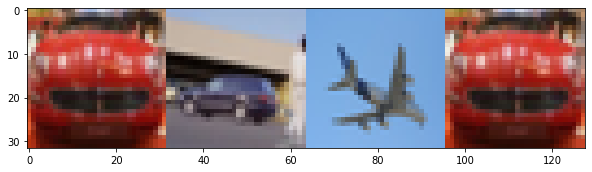

In [31]:
X_batch, y_batch = get_batch(X_train, y_train, 4)
plt.imshow(make_random_grid(X_batch, y_batch));

In [32]:
# predictions
print(' '.join('%13s' % classes[y_pred[j]] for j in range(4)))

        plane         plane           car         plane


In [33]:
print("model accuracy: ", logistic.calc_accuracy(X_train, y_train))

model accuracy:  0.6341


## Binary cross-entropy

Your code for this section will written in the next cell. 

Complete the function `binary_cross_entropy` using vectorized code. This function takes as input the weights, data, labels and outputs the calculated loss as a single number and the gradients with respect to W. (**20 points**)

In [34]:
def binary_cross_entropy(W, X, y):
    """
    Structured BCE loss function. Implement this function using vectorized code.
    Inputs:
    - W: array of weights
    - X: array of data
    - y: 1-dimensional array of length N with binary labels (0,1). 
    Returns:
    a tuple of:
    - loss as single float
    - gradient with respect to weights W; an array of same shape as W
    """
    loss = 0.0
    dW = np.zeros(W.shape) # initialize the gradient as zero
    #############################################################################
    # TODO:                                                                     #
    # Implement the function and store result in loss and the gradint in dW     #
    # Note: in class you defined BCE that takes values from the range (-1,1).   #
    # and the sigmoid function generally outputs values in the range (0,1).     #
    # Make the proper adjustments for your code to work.                        #
    #############################################################################

    t = np.where(y == 1, y, -1)
    z = W.T @ X.T
    tz = np.multiply(t, z)
    loss -= np.mean(np.log(sigmoid(tz)))
    tx = t.T * X.T
    res = sigmoid(-tz) * tx
    dW -= 1/X.shape[0]*(np.expand_dims(np.sum(sigmoid(-tz) * tx, axis=1), axis=1)) 

    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################
    return loss, dW

In [35]:
W = np.random.randn(3073, 1) * 0.0001

In [36]:
%%time
loss_naive, grad_naive = binary_cross_entropy(W, X_val, y_val)
print ('loss: %f' % (loss_naive, ))

loss: 0.643279
CPU times: user 42.1 ms, sys: 32 ms, total: 74.1 ms
Wall time: 40.9 ms


You are provided with a gradient test in the next cells:

In [37]:
def grad_check(f, x, analytic_grad, num_checks=10, h=1e-5):
    for i in range(num_checks):
        ix = tuple([randrange(m) for m in x.shape])

        oldval = x[ix]
        x[ix] = oldval + h # increment by h
        fxph = f(x) # evaluate f(x + h)
        x[ix] = oldval - h # increment by h
        fxmh = f(x) # evaluate f(x - h)
        x[ix] = oldval # reset

        grad_numerical = (fxph - fxmh) / (2 * h)
        grad_analytic = analytic_grad[ix]
        rel_error = abs(grad_numerical - grad_analytic) / (abs(grad_numerical) + abs(grad_analytic))
        print ('numerical: %f analytic: %f, relative error: %e' % (grad_numerical, grad_analytic, rel_error))

In [38]:
loss, grad = binary_cross_entropy(W, X_val, y_val)
f = lambda w: binary_cross_entropy(w, X_val, y_val)[0]
grad_numerical = grad_check(f, W, grad)

numerical: 4.651397 analytic: 4.651397, relative error: 1.917136e-08
numerical: 6.567442 analytic: 6.567441, relative error: 2.048954e-08
numerical: 5.271031 analytic: 5.271031, relative error: 1.815126e-08
numerical: 4.131502 analytic: 4.131502, relative error: 1.458435e-08
numerical: 2.509532 analytic: 2.509532, relative error: 2.345996e-08
numerical: -1.598289 analytic: -1.598289, relative error: 3.669677e-08
numerical: -3.284739 analytic: -3.284739, relative error: 1.850130e-08
numerical: -0.599409 analytic: -0.599409, relative error: 1.076126e-07
numerical: 1.614103 analytic: 1.614103, relative error: 4.912723e-08
numerical: 5.667864 analytic: 5.667864, relative error: 1.644301e-08


If implemented correctly, the training procedure you already implemented should work.

In [39]:
%%time
logistic = LogisticRegression(X_train, y_train)
loss_history = logistic.train(X_train, y_train, 
                         learning_rate=1e-7,
                         num_iters=1500,
                         verbose=True)

iteration 0 / 1500: loss 0.796561
iteration 100 / 1500: loss 0.449298
iteration 200 / 1500: loss 0.454666
iteration 300 / 1500: loss 0.442765
iteration 400 / 1500: loss 0.425203
iteration 500 / 1500: loss 0.476461
iteration 600 / 1500: loss 0.417799
iteration 700 / 1500: loss 0.468939
iteration 800 / 1500: loss 0.463245
iteration 900 / 1500: loss 0.409112
iteration 1000 / 1500: loss 0.447044
iteration 1100 / 1500: loss 0.353742
iteration 1200 / 1500: loss 0.383748
iteration 1300 / 1500: loss 0.393486
iteration 1400 / 1500: loss 0.424342
CPU times: user 14.6 s, sys: 15.4 s, total: 30 s
Wall time: 15.6 s


Text(0.5, 0, 'Iteration number')

Text(0, 0.5, 'Loss value')

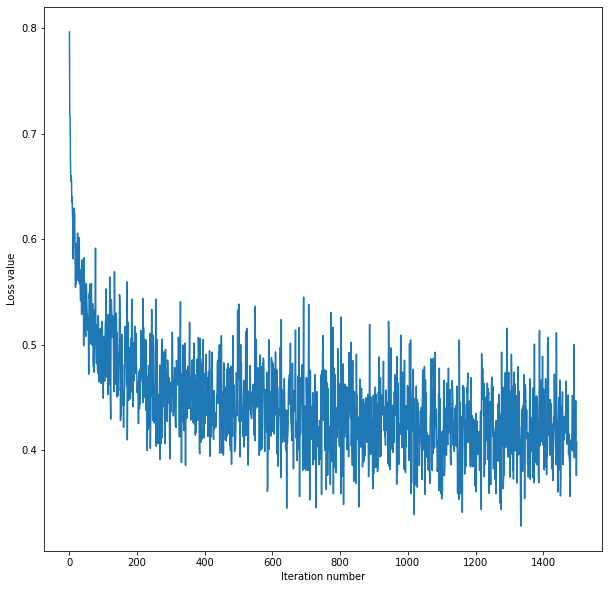

In [40]:
plt.plot(loss_history)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [41]:
print("Training accuracy: ", logistic.calc_accuracy(X_train, y_train))
print("Testing accuracy: ", logistic.calc_accuracy(X_test, y_test))

Training accuracy:  0.8142
Testing accuracy:  0.824


## Hyperparameter optimization

Your model should have improved from 50% accuracy to ~75% accuracy in a matter of seconds. Now, use the validation set to tune hyperparameters by training different models (using the training dataset) and evaluating the performance using the validation dataset. Save the results in a dictionary mapping tuples of the form `(learning_rate, batch_size)` to tuples of the form `(training_accuracy, validation_accuracy)`. Finally, you should evaluate the best model on the testing dataset. 

Note: When changing the batch_size, change the number of iterations accordingly such that the number of epochs on the data stays roughly the same. A reasonable ratio is 600 iterations for a batch size of 200. 

If you are carful you should reach ~83% accuracy on the validation dataset.

Use a small value for the number of iterations as you develop your code. Once you are confident that everything works, run it again for more iterations. Finally, explain the results - what can you learn from the hyper parameters that yields the best results? Why do you think that is the case? **(5 points)**

In [42]:
# You are encouraged to experiment with additional values

learning_rates = [1e-7, 5e-6, 1e-3, 1e-2]
batch_sizes = [1, 32, 100, 200, 500, 1000, 10000]


results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_logistic = None # The LogisticRegression object that achieved the highest validation rate.

################################################################################
#                            START OF YOUR CODE                                #
################################################################################


n_epochs = 12
num_iters_lst = [int(X_train.shape[0]/b * n_epochs) for b in batch_sizes]
print(f'Tuning on batch size and learning rate with {n_epochs} epochs number per training')

np.random.seed(100)

for batch, num_iters in zip(batch_sizes, num_iters_lst):
    for lr in learning_rates:
        logistic = LogisticRegression(X_train, y_train)
        _ = logistic.train(X_train, y_train, 
            learning_rate=lr,
            batch_size=batch,
            num_iters=num_iters, 
            verbose=True)
        
        training_accuracy = logistic.calc_accuracy(X_train, y_train)
        validation_accuracy = logistic.calc_accuracy(X_val, y_val)
        results[(lr, batch)] = (training_accuracy, validation_accuracy)
        
        # update if found better model
        if validation_accuracy > best_val:
            best_logistic = logistic
            best_val = validation_accuracy
                                                       
        
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, batch_size in sorted(results):
    train_accuracy, val_accuracy = results[(lr, batch_size)]
    print ('lr %e batch_size %e train accuracy: %f val accuracy: %f' % (
                lr, batch_size, train_accuracy, val_accuracy))
    
print ('best validation accuracy achieved during cross-validation: %f' % best_val)

test_accuracy = best_logistic.calc_accuracy(X_test, y_test)
print ('Binary logistic regression on raw pixels final test set accuracy: %f' % test_accuracy)

Tuning on batch size and learning rate with 12 epochs number per training
iteration 0 / 120000: loss 0.488335
iteration 100 / 120000: loss 0.312200
iteration 200 / 120000: loss 1.343056
iteration 300 / 120000: loss 3.748479
iteration 400 / 120000: loss 0.056739
iteration 500 / 120000: loss 0.697374
iteration 600 / 120000: loss 0.252637
iteration 700 / 120000: loss 0.435013
iteration 800 / 120000: loss 2.379549
iteration 900 / 120000: loss 0.383903
iteration 1000 / 120000: loss 0.218630
iteration 1100 / 120000: loss 0.072865
iteration 1200 / 120000: loss 0.013313
iteration 1300 / 120000: loss 0.857362
iteration 1400 / 120000: loss 0.672361
iteration 1500 / 120000: loss 0.219448
iteration 1600 / 120000: loss 3.350412
iteration 1700 / 120000: loss 0.077590
iteration 1800 / 120000: loss 0.158270
iteration 1900 / 120000: loss 0.144608
iteration 2000 / 120000: loss 1.643179
iteration 2100 / 120000: loss 0.054618
iteration 2200 / 120000: loss 0.070504
iteration 2300 / 120000: loss 0.497427
it

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in exp
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log


iteration 400 / 120000: loss inf
iteration 500 / 120000: loss 0.000000
iteration 600 / 120000: loss 0.000000
iteration 700 / 120000: loss inf
iteration 800 / 120000: loss 0.000000
iteration 900 / 120000: loss 0.000000
iteration 1000 / 120000: loss 0.000000
iteration 1100 / 120000: loss inf
iteration 1200 / 120000: loss 0.000000
iteration 1300 / 120000: loss inf
iteration 1400 / 120000: loss 0.000000
iteration 1500 / 120000: loss 0.000000
iteration 1600 / 120000: loss 0.000000
iteration 1700 / 120000: loss inf
iteration 1800 / 120000: loss 0.000000
iteration 1900 / 120000: loss inf
iteration 2000 / 120000: loss 0.000000
iteration 2100 / 120000: loss 0.000000
iteration 2200 / 120000: loss inf
iteration 2300 / 120000: loss inf
iteration 2400 / 120000: loss 0.000000
iteration 2500 / 120000: loss 0.000000
iteration 2600 / 120000: loss 0.000000
iteration 2700 / 120000: loss inf
iteration 2800 / 120000: loss 0.000000
iteration 2900 / 120000: loss inf
iteration 3000 / 120000: loss 0.000000
ite

In [43]:
best_accuracy = max(results.values(), key=lambda x: x[1])
best_params = get_key(results, best_accuracy)
print(f'The best model is with learning rate of {best_params[0]} and batch size of {best_params[1]}')

The best model is with learning rate of 1e-07 and batch size of 32


In [44]:
results

{(1e-07, 1): (0.8288, 0.82),
 (1e-07, 32): (0.8233, 0.828),
 (1e-07, 100): (0.8125, 0.816),
 (1e-07, 200): (0.805, 0.818),
 (1e-07, 500): (0.7931, 0.802),
 (1e-07, 1000): (0.7805, 0.792),
 (1e-07, 10000): (0.6668, 0.69),
 (5e-06, 1): (0.8161, 0.793),
 (5e-06, 32): (0.8295, 0.819),
 (5e-06, 100): (0.6745, 0.645),
 (5e-06, 200): (0.8123, 0.819),
 (5e-06, 500): (0.8201, 0.822),
 (5e-06, 1000): (0.8025, 0.797),
 (5e-06, 10000): (0.7777, 0.78),
 (0.001, 1): (0.8073, 0.772),
 (0.001, 32): (0.6105, 0.584),
 (0.001, 100): (0.7877, 0.784),
 (0.001, 200): (0.6581, 0.653),
 (0.001, 500): (0.7868, 0.789),
 (0.001, 1000): (0.8121, 0.82),
 (0.001, 10000): (0.7853, 0.784),
 (0.01, 1): (0.7859, 0.768),
 (0.01, 32): (0.7911, 0.784),
 (0.01, 100): (0.8247, 0.821),
 (0.01, 200): (0.8239, 0.818),
 (0.01, 500): (0.7743, 0.777),
 (0.01, 1000): (0.7207, 0.722),
 (0.01, 10000): (0.7981, 0.804)}

As in the Linear Perceptron, the best hyperparameters values were not consistent even with the same random seed. Again, we see that mini-batch was found to be the best method. 
In this run, the batch size is relatively small and is 32 which was mentioned many times as a recommended default value online. 


## Weight Visualization

(-0.5, 31.5, 31.5, -0.5)

Text(0.5, 1.0, 'car')

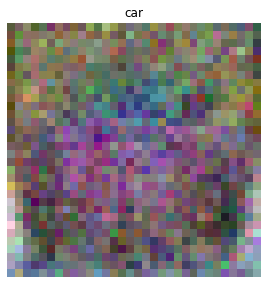

(-0.5, 31.5, 31.5, -0.5)

Text(0.5, 1.0, 'car')

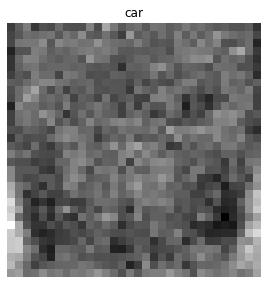

In [76]:
w = best_perceptron.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 1)
w_min, w_max = np.min(w), np.max(w)
classes = ['car']
for i in range(1):

    plt.subplot(1, 2, i + 1)
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

    plt.figure(1)
    wimg = np.sum(wimg, axis=2)/3
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i]);

(-0.5, 31.5, 31.5, -0.5)

Text(0.5, 1.0, 'car')

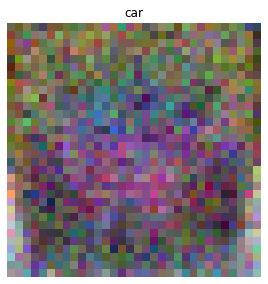

(-0.5, 31.5, 31.5, -0.5)

Text(0.5, 1.0, 'car')

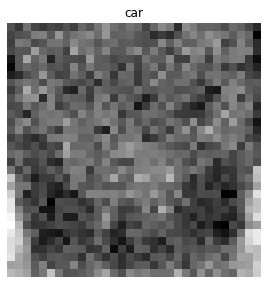

In [75]:
w = best_logistic.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 1)
w_min, w_max = np.min(w), np.max(w)
classes = ['car']
for i in range(1):

    
    plt.subplot(1, 2, i + 1)
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

    plt.figure(1)
    wimg = np.sum(wimg, axis=2)/3
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

**Question:** Explain the possible reasons for the differences in the visualization of the weights in the both cases, also are the car weights for the perceptron and logistic models similiar? what can you say about that? **(5 points)**

One can see by eyeball from the weights visualization that the weights are very similar. This makes sense, both output eventually a linear separator that makes its prediction based on a linear predictor function (combine the weights with the feature vectors). Both classifiers have the same function mapping  𝑓(𝑥𝑖;𝑊,𝑏)=𝑊⋅𝑥𝑖+𝑏 however the interpretation of the scores is different. In Logistic Regression, the output function - Sigmoid, provides a natural cutoff point for the classification and gives probabilistic connotations. As both best classifiers achieved similar performance ~0.82 therefore, it makes sense the weights look so similar. 

In general, the weights’ values are the scalar we multiple with the input, and therefore from their visualization, we can interpret how the network outputs a prediction especially in a shallow classifier as perceptron and logistic regression. High values will give high values on the output and low values will give low values in the direction. In some cases, we can actually see in the predicted class weight matrix the class itself (as seeing digits in the MNSIT dataset). However, in this case, it is less clear that the weights represent a car in both algorithms. The reason why we would expect to see a vague 'car' shape is due to the fact that neurons that are responsible to classify a 'car', their goal is to output a high value for cars and a low value for non-cars. so, high outputs for cars get by having large weights aligned to pixels which tend to usually be high in images of cars. Simultaneously, it can obtain relatively low outputs for non-cars by having small weights aligned to pixels which tend to be high in images of non-cars and low in images of cars. So we can expect relatively black areas in the weights’ image where images of cars tend to be off there, but are usually higher for other classes.
Being said that the lower corners have high values which can represent the wheels of the car.

# The End!